# Lecture 22: Understanding Neural Networks Architecture

Backpropagation is a cornerstone algorithm for training modern neural networks. At its core, backpropagation is a method for computing gradients of the loss function with respect to the weights of the network efficiently and effectively. This process involves two main steps: a forward pass and a backward pass. 

In the forward pass, data moves through the network, and its output is compared to the expected output to calculate the loss. The backward pass then propagates this loss backward through the network, from the output layer to the input layer, calculating the gradient of the loss function with respect to each weight by the chain rule. This information is then used to update the weights in a direction that minimally reduces the loss, typically through gradient descent or its variants.

Understanding backpropagation is crucial because it underpins the learning process of deep learning models, allowing them to adjust their parameters and improve their predictions based on the feedback from the loss function.


### Set up imports

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from skimage.color import rgb2gray
from skimage.filters import sobel

### Load images from CIFAR-10 Dataset

The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. [Learn more about CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

In [3]:
# use this function to load the CIFAR-10 dataset from the data folder
def load_cifar_batch(filename):
    """Load a single batch of CIFAR-10."""
    with open(filename, 'rb') as file:
        # The encoding 'bytes' is required for Python 3 compatibility
        batch = pickle.load(file, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        # Reshape the images: the dataset is flattened, so you need to reshape it to 32x32x3
        images = images.reshape((len(images), 3, 32, 32)).transpose(0, 2, 3, 1)
        labels = np.array(labels)
        return images, labels

In [4]:
# load batch 1 of CIFAR-10
file_name = 'data/batch_1'

images, labels = load_cifar_batch(file_name)


### Inspect images and labels

Understanding the structure and format of our dataset is crucial. Let’s start by examining the lengths of images and labels to get a sense of the dataset's size.

In [5]:
# look at length of images and labels
print(len(images))
print(len(labels))

10000
10000


### Inspect the first three images

Visualizing our data is just as important as understanding its structure. Let’s display the first few images from our dataset along with their corresponding labels to see what we’re working with.


0


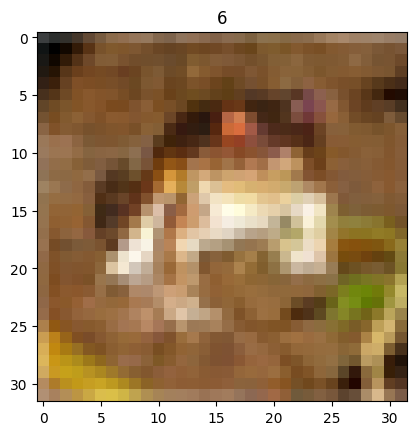

1


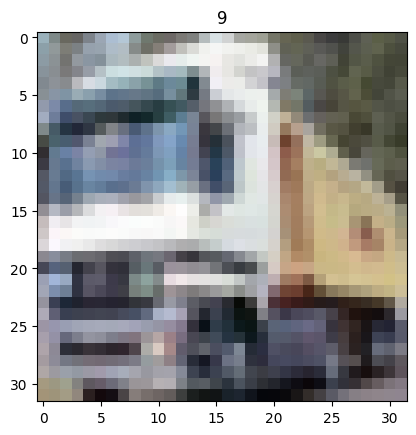

2


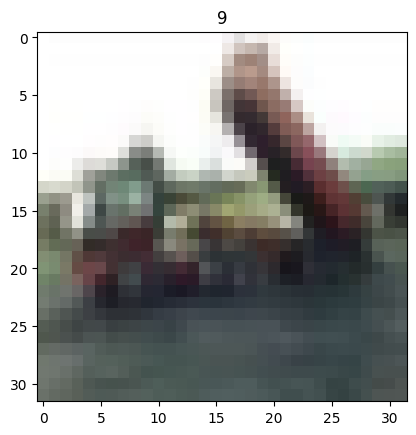

In [6]:
# Function to show an image
def show_image(img, label):
    plt.imshow(img)
    plt.title(label)
    plt.show()

# Show the first three images
for index in range(3):
    print(index)
    show_image(images[index], labels[index])

### Define labels
Each image in CIFAR-10 is associated with a label from 10 classes. Here, we define a list of label names to make our data more understandable.


In [7]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_names


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Inspect the first label

To further familiarize ourselves with the dataset, let's inspect the label of the first image. This step helps us connect an image with its categorical representation.


In [8]:
# inspect first label
first_label = labels[0]

label_names[first_label]

'frog'

In [9]:
# look at first image data
images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

### Preprocess data

Data preprocessing is a critical step in any machine learning workflow. Here, we'll normalize pixel values to improve our model's convergence during training. We'll also reshape the data to fit our model's input requirements.


In [10]:
# Normalize pixel values to be between 0 and 1
images_normalized = images / 255.0

images_normalized[0]


array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

In [11]:
# inspect the shape of the images
images_normalized.shape


(10000, 32, 32, 3)

In [12]:
# Flatten the images
images_flattened = images_normalized.reshape(images_normalized.shape[0], -1)

In [13]:
# inspect flattened images
images_flattened.shape

(10000, 3072)

In [14]:
32 * 32 * 3

3072

### Splitting Dataset into Training and Test Sets

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

In [16]:
# check that it worked
X_train.shape

(8000, 3072)

### Training a Machine Learning Model
This time use an MLPClassifier (Neural Network) with 2 hidden layers with 16 nodes each. Use the 'relu' activation function, and a maximum of 200 iterations.

In [17]:
# Initialize the model
model = MLPClassifier(
  hidden_layer_sizes=(16,16), 
  activation='relu', 
  max_iter=200, 
  random_state=42, 
  verbose=True
)

# Train the model
model.fit(X_train, y_train)

Iteration 1, loss = 2.28431233
Iteration 2, loss = 2.20343275
Iteration 3, loss = 2.13610423
Iteration 4, loss = 2.06552383
Iteration 5, loss = 2.01285519
Iteration 6, loss = 1.98125402
Iteration 7, loss = 1.95859182
Iteration 8, loss = 1.93993517
Iteration 9, loss = 1.92535824
Iteration 10, loss = 1.91058834
Iteration 11, loss = 1.90675822
Iteration 12, loss = 1.89209690
Iteration 13, loss = 1.88369548
Iteration 14, loss = 1.88402371
Iteration 15, loss = 1.88238091
Iteration 16, loss = 1.87138637
Iteration 17, loss = 1.86324858
Iteration 18, loss = 1.84599807
Iteration 19, loss = 1.83913007
Iteration 20, loss = 1.83142168
Iteration 21, loss = 1.83496510
Iteration 22, loss = 1.82469247
Iteration 23, loss = 1.81583375
Iteration 24, loss = 1.81557710
Iteration 25, loss = 1.80401580
Iteration 26, loss = 1.80606947
Iteration 27, loss = 1.81151340
Iteration 28, loss = 1.79507527
Iteration 29, loss = 1.78853126
Iteration 30, loss = 1.79027577
Iteration 31, loss = 1.78899894
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(16, 16), random_state=42, verbose=True)

### Inspect the model

In [22]:
# look at all the weights in the model using ._coefs
type(model.coefs_)
len(model.coefs_)

3

In [25]:
# Look at the shape of the coefficients (weights) in first layer 
model.coefs_[0].shape

(3072, 16)

In [26]:
# Look at the shape of the coefficients (weights) in second layer
model.coefs_[1].shape

(16, 16)

In [27]:
# print the shape of each layer of weights (coefficients)
print(model.coefs_[0].shape)
print(model.coefs_[1].shape)
print(model.coefs_[2].shape)

(3072, 16)
(16, 16)
(16, 10)


In [30]:
# print the shape of each layer of biases (intercepts)
print(model.intercepts_[0].shape)
print(model.intercepts_[1].shape)
print(model.intercepts_[2].shape)

(16,)
(16,)
(10,)


### Plot distributions of weights and biases in layer

(49152,)


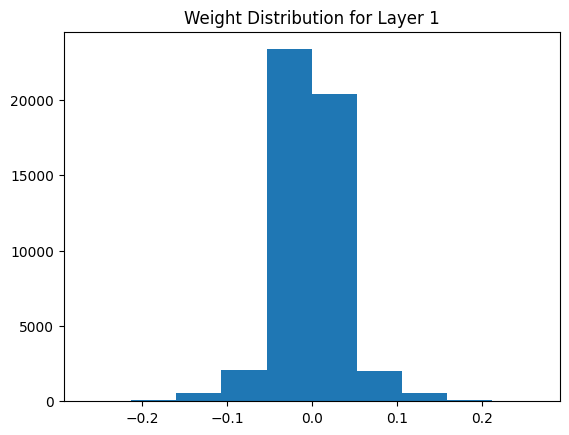

(256,)


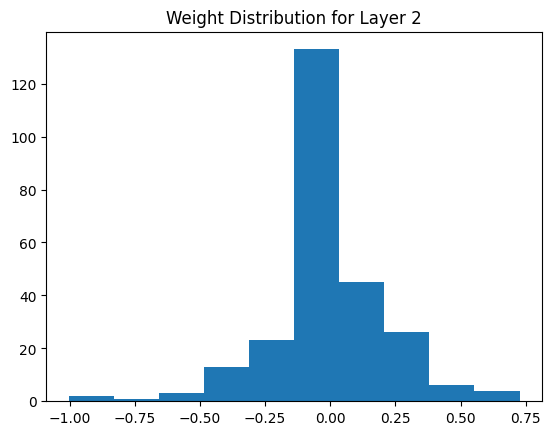

(160,)


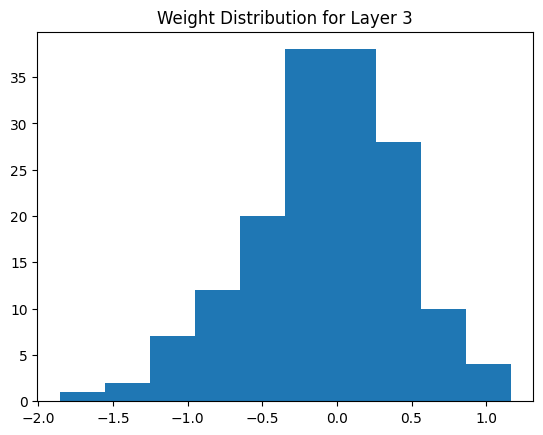

In [39]:
# Plot distributions of weights and biases in layer
for index, weights in enumerate(model.coefs_):
    all_weights = weights.flatten()
    print(all_weights.shape)

    plt.hist(all_weights)
    plt.title(f'Weight Distribution for Layer {index + 1}')

    plt.show()

### Activity 1
How does neural network shape affect the number of parameters?

In [51]:
# Determine the total number of parameters (weights plus biases) in a model with 
# two hidden layers of size 16 and 16, respectively, and an output layer of size 10

# Initialize the model
model = MLPClassifier(
  hidden_layer_sizes=(16,16), 
  max_iter=1,
)

# train model to generate coefs_ array
model.fit(X_train, y_train)

sum_params = 0
for weights, biases in zip(model.coefs_, model.intercepts_):

    # first sum the weights
    flat_weights = weights.flatten()
    num_weights = len(flat_weights)

    # then sum the biases
    flat_biases = biases.flatten()
    num_biases = len(flat_biases)


    sum_params += num_weights

print(sum_params)

49568


/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [52]:
# Determine the total number of parameters (weights plus biases) in a model with 
# two hidden layers of size 32 and 32, respectively, and an output layer of size 10

# Initialize the model
model = MLPClassifier(
  hidden_layer_sizes=(32,32), 
  max_iter=1,
)

# train model to generate coefs_ array
model.fit(X_train, y_train)

sum_params = 0
for weights, biases in zip(model.coefs_, model.intercepts_):

    # first sum the weights
    flat_weights = weights.flatten()
    num_weights = len(flat_weights)

    # then sum the biases
    flat_biases = biases.flatten()
    num_biases = len(flat_biases)


    sum_params += num_weights

print(sum_params)

99648


/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
# Write a function that takes in a list of hidden layer sizes and 
# returns the total number of parameters in the model

def count_parameters(hidden_layer_sizes):
    # Initialize the model
    model = MLPClassifier(
      hidden_layer_sizes=hidden_layer_sizes, 
      max_iter=1,
    )

    # train model to generate coefs_ array
    model.fit(X_train, y_train)

    sum_params = 0
    for weights, biases in zip(model.coefs_, model.intercepts_):

        # first sum the weights
        flat_weights = weights.flatten()
        num_weights = len(flat_weights)

        # then sum the biases
        flat_biases = biases.flatten()
        num_biases = len(flat_biases)


        sum_params += num_weights

    return sum_params

# Test the function
count_parameters((16,16))


/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


49568

In [61]:
# Use a loop to fill a dataframe with the number of parameters for models with
# two hidden layers with sizes ranging from 1 to 100, in increments of 10

hidden_layer_sizes = list(range(0, 101, 10))
hidden_layer_sizes[0] = 1

data = {}

for size in hidden_layer_sizes:
    params = count_parameters((size, size))

    data[size] = params

data_df = pd.DataFrame(data.items(), columns=['hidden_layer_size', 'num_parameters'])

data_df

/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-22/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached 

,hidden_layer_size,num_parameters
0,1,3083
1,10,30920
2,20,62040
3,30,93360
4,40,124880
5,50,156600
6,60,188520
7,70,220640
8,80,252960
9,90,285480


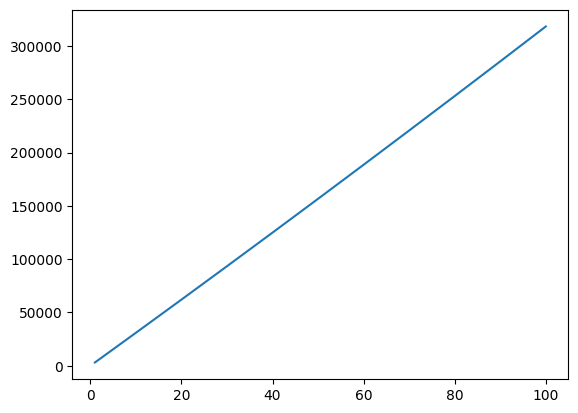

In [62]:
# Plot the number of parameters as a function of the size of the hidden layers
plt.plot(data_df['hidden_layer_size'], data_df['num_parameters'])

### Activity 2
Tracking the value of a single parameter over many iterations

In [ ]:
# for the model with two hidden layers of size 16 and 16, trained for 150 iterations
# find the first bias value in the first hidden layer


In [ ]:
# write a function that takes in a number of iterations,
# and returns the value of the first bias in the first hidden layer

In [ ]:
# write a loop that adds the value of the first bias in the first hidden layer
# for models trained for 1 to 150 iterations, in increments of 10

In [ ]:
# plot the value of the first bias in the first hidden layer 
# as a function of the number of iterations